Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 3: k-Nearest Neighbors & Logistic Regression

Jérémie DECOCK - Adrien EHRHARDT

## Objectives

- Implement Logistic Regression and *(k)-Nearest Neighbor(s)*
- Use it to solve classification and regression problems
- Define the decision boundaries
- Explain the weaknesses of these algorithms

## Imports and tool functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import sklearn.neighbors
from sklearn.utils import shuffle
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
def gen_2d_classification_samples(n_samples: int = 20, nclass: int = 3) -> pd.DataFrame:
    """
    Generates 2-dimensional samples which belong to either 2 or 3 classes

    :param int n_samples: number of samples to draw per class
    :param int nclass: number of classes the samples belong to (either 2 or 3)
    :returns: dataframe containing X (2 coordinates x1, x2) and y (as int!)
    """
    cov = np.diag([2., 2.])

    x1 = np.random.multivariate_normal(mean=[0., 0.], cov=cov, size=n_samples)
    y1 = np.full(n_samples, 1, dtype=int)

    x2 = np.random.multivariate_normal(mean=[4., 0.], cov=2.5*cov, size=n_samples)
    y2 = np.full(n_samples, 2, dtype=int)

    x3 = np.random.multivariate_normal(mean=[2., 4.], cov=cov, size=3*n_samples)
    y3 = np.full(3*n_samples, 3, dtype=int)

    if nclass == 3:
        X = np.concatenate([x1, x2, x3])
        y = np.concatenate([y1, y2, y3])
    elif nclass == 2:
        X = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
    else:
        raise ValueError("Only 2 or 3 classes")

    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y

    df = shuffle(df).reset_index(drop=True)
    
    return df

In [ ]:
def gen_and_plot_1d_regression_samples(n_samples : int = 40):
    """
    Generates 1-dimensional regression samples

    :param int n_samples: number of samples to draw
    :returns: dataframe containing X (1 coordinate x) and y
    """
    x = np.random.uniform(low=-10., high=10., size=n_samples)
    # This is y = 2x + 3 + epsilon, similar to lab_session_02
    y = -2. * x + 1. + np.random.normal(scale=4., size=x.shape)

    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df.plot.scatter(x='x', y='y');
    return df

In [ ]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_2d_classification_samples(dataframe: pd.DataFrame, model=None,
                                   voronoi: bool = False):
    """
    Plots the 2D classification problem, possibly with the results of a given model and the Voronoi cells.
    """
    plt.figure(figsize=(8, 8))
    df = dataframe  # make an alias so as not to modify dataframe
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x1', 'x2', 'y']"
    assert df.columns.values.tolist() == ['x1', 'x2', 'y'], ERROR_MSG1
    
    ERROR_MSG2 = "The `dataframe` parameter should be a Pandas DataFrame having the following labels (in column 'y'): [1, 2, 3]"
    labels = pd.unique(df.y).tolist()
    labels.sort()
    assert labels == [1, 2, 3] or labels == [1, 3] or labels == [1, 2], ERROR_MSG2

    if model is not None:
        if voronoi:
            # Compute the Voronoi cells            
            vor = Voronoi(df[['x1', 'x2']])

            # Plot the Voronoi diagram
            fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False);
            fig.set_size_inches(8, 8);
        
        # Compute the model's decision boundaries
        h = .02  # step size in the mesh
        x_min, x_max = df.x1.min() - 1, df.x1.max() + 1
        y_min, y_max = df.x2.min() - 1, df.x2.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the model's decision boundaries
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5, shading="auto")

    # Plot also the training points
    plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", fontsize=16)

## Logistic Regression (Gradient Descent)

$k$-NN is a **non-parametric**, **classification** (with arbitrary number of classes) and **regression** algorithm.

Logistic regression is a **parametric binary classification algorithm**, so we generate a dataframe `df` containing a label `y` with only 2 classes (`0` and `1`).

In [ ]:
df = gen_2d_classification_samples(n_samples = 100, nclass = 2)

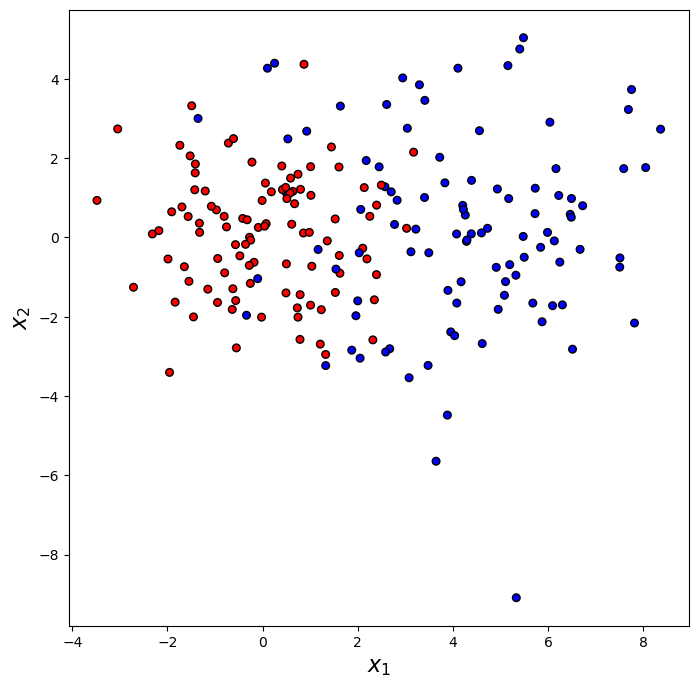

In [ ]:
plot_2d_classification_samples(df)

In [ ]:
X = np.array([np.ones((df.shape[0])), df.x1, df.x2])
y = np.array(df.y) - 1

Logistic regression is very similar to linear regression in so far as it is a **parametric model** which aims at finding a parameter $\boldsymbol{\theta}^\star$ such as $f_{\boldsymbol{\theta}}: \boldsymbol{x} \mapsto y$ provides a good "link" between input vectors $\boldsymbol{x} \in \mathbb{R}^p$ and output values $y \in \{0,1\}$ in a *learning set* $\mathcal{D} = \{(\boldsymbol{x}^{(i)}, y^{(i)})\}_{1 \leq i \leq n}$ of $n$ examples:

$$
\boldsymbol{\theta}^\star = \arg\!\min E(\boldsymbol{\theta}, \mathcal{D}),
$$

where $E(\boldsymbol{\theta}, \mathcal{D}) = - \sum_{i=1}^n \ln p_{\boldsymbol{\theta}}(y^{(i)} | \boldsymbol{x}^{(i)})$.

This is called the log loss (machine learning community), or the negative loglikelihood (statistics community).

Fortunately, logistic regression is a rather simple model which states:

$$
p_{\boldsymbol{\theta}}(1 | \boldsymbol{x}^{(i)}) = \frac{1}{1+\exp{(-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)})}}
$$

The loss function $E(\boldsymbol{\theta}, \mathcal{D})$ is convex, which means $\boldsymbol{\theta}^\star$ exists, is unique, and can be obtained by minimizing $E$.

### Exercise 1

Complete the following `gradient_descent` function implemented in the last lab to work for logistic regression. 

**Hint**: only the gradient needs to be changed.

In [ ]:
def gradient_descent(X, y, eta=0.001, max_iteration=10000, initial_theta=None):

    if initial_theta is None:
        # The initial solution is selected randomly
        theta = np.random.normal(loc=0, scale=10, size=[3, 1])
    else:
        theta = initial_theta
    print(theta.shape)
    print(X.shape)
    grad_list = []      # Keep the gradient of all iterations
    theta_list = []     # Keep the solution of all iterations
    
                   

    for i in range(max_iteration):
        # Perform the gradient descent here
        # YOUR CODE HERE
        sigm=1/(1+np.exp(-np.dot(theta.T,X)))
        grad = np.dot(X,(sigm-y).T)
        theta = theta- eta * grad
        
        grad_list.append(grad)      # Keep the gradient
        theta_list.append(theta)   # Keep the solution


    return grad_list, theta_list

(You don't have to fill in anything in the following cell; it's a general comment about the solution of the previous cell which will be provided in the solutions of this lab session.)

YOUR ANSWER HERE

In [ ]:
grad_list, theta_list = gradient_descent(X, y, eta = 0.001)

(3, 1)
(3, 200)


Let's see if it has converged by plotting the parameters w.r.t. the iteration number:

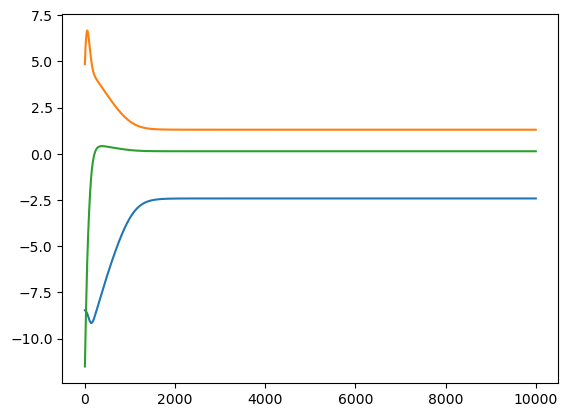

In [ ]:
plt.plot([theta[0] for theta in theta_list]);
plt.plot([theta[1] for theta in theta_list]);
plt.plot([theta[2] for theta in theta_list]);

Let's see the decision boundary, i.e. the half-spaces where each label is predicted.

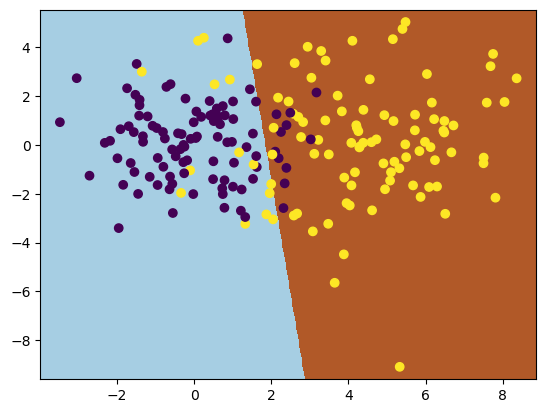

In [ ]:
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = 1 / (1 + np.exp(-np.dot(np.c_[np.ones((len(xx.ravel()))),
                                  xx.ravel(), yy.ravel()], theta_list[9999])))
plt.pcolormesh(xx, yy, (Z.reshape(xx.shape) > 0.5)*1, cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=y);

## Logistic Regression (scikit-learn)

### Exercise 2

Let's do the same using scikit-learn!

Similar to the previous lab, logistic regression belongs to the linear model module, and provides among others the `fit` and `predict` methods. Use the `fit` method to compare the coefficients obtained with scikit-learn and your gradient descent.

**Beware of the `C` parameter**, which corresponds to L2 regularization (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) - this will be the subject of subsequent lectures; set it to an arbitrarily high value, e.g. `1e9`.

In [ ]:
# Uncomment and provide the appropriate parameters:
model = sklearn.linear_model.LogisticRegression(C=1e9)
model.fit(X[1:].T, y)

LogisticRegression(C=1000000000.0)

Let's see if we came up with the same estimates:

In [ ]:
print("Intercept")
print("=========")
print("sklearn:\t\t", model.intercept_[0])
print("gradient descent: \t", theta_list[9999][0])
print("\n")

print("theta_1")
print("=========")
print("sklearn:\t\t", model.coef_[0][0])
print("gradient descent:\t", theta_list[9999][1])
print("\n")

print("theta_2")
print("=========")
print("sklearn:\t\t", model.coef_[0][1])
print("gradient descent:\t", theta_list[9999][2])

Intercept
sklearn:		 -2.4143345536842338
gradient descent: 	 [-2.41433389]


theta_1
sklearn:		 1.3060196055790398
gradient descent:	 [1.30601902]


theta_2
sklearn:		 0.13959182750854532
gradient descent:	 [0.13959195]


## Logistic Regression with Polynomial Basis Functions

We will now generate some data with a non-linear boundary between classes to illustrate the power of the logistic regression classifier with polynomial basis function features as input. 

In [ ]:
def gen_nonlinear_2d_classification_samples(n_samples: int = 20, nclass: int = 3) -> pd.DataFrame:
    """
    Generates 2-dimensional samples which belong to either 2 or 3 classes

    :param int n_samples: number of samples to draw per class
    :param int nclass: number of classes the samples belong to (either 2 or 3)
    :returns: dataframe containing X (2 coordinates x1, x2) and y (as int!)
    """
    cov1 = np.diag([2., 2])
    cov2 = np.diag([6., 2])

    x1 = np.random.multivariate_normal(mean=[-3., 0.], cov=cov1, size=n_samples)
    y1 = np.full(n_samples, 1, dtype=int)
    x2 = np.random.multivariate_normal(mean=[3., 6], cov=cov1, size=n_samples)
    y2 = np.full(n_samples, 1, dtype=int)
    x3 = np.random.multivariate_normal(mean=[3., -6.], cov=cov1, size=n_samples)
    y3 = np.full(n_samples, 1, dtype=int)

    x4 = np.random.multivariate_normal(mean=[3., 0.], cov=cov2, size=n_samples)
    y4 = np.full(n_samples, 2, dtype=int)

    if nclass == 2:
        X = np.concatenate([x1, x2, x3, x4])
        y = np.concatenate([y1, y2, y3, y4])
    else:
        raise ValueError("Only 2 or 3 classes")

    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y

    df = shuffle(df).reset_index(drop=True)
    
    return df

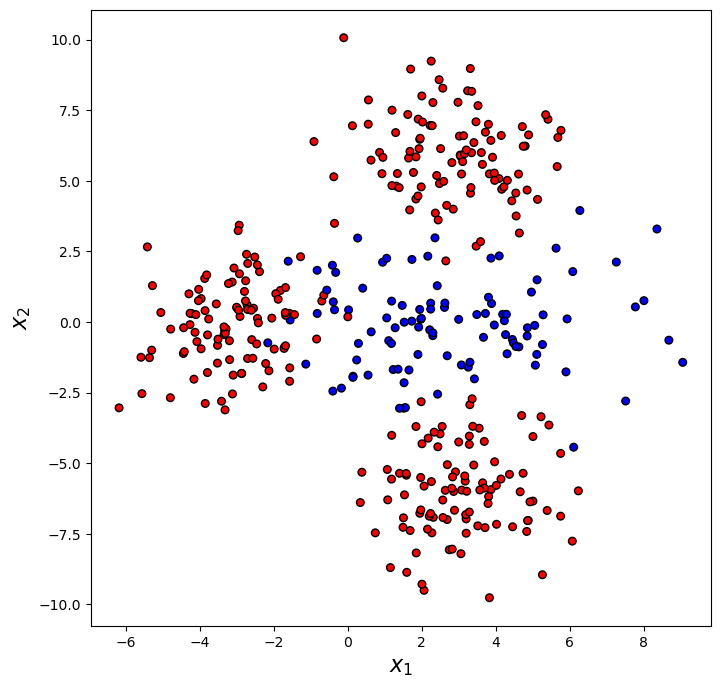

In [ ]:
df = gen_nonlinear_2d_classification_samples(n_samples=100, nclass=2)
plot_2d_classification_samples(df)

In [ ]:
df

,x1,x2,y
0,5.067407,-1.525714,2
1,-3.414187,-2.802998,1
2,2.908785,-5.304370,1
3,3.467290,2.689020,1
4,-5.590448,-1.245225,1
...,...,...,...
395,3.200925,6.095553,1
396,-2.793794,1.085208,1
397,5.256921,-8.947443,1
398,0.238561,-1.341293,2


### Exercise 3

Please fit two logisic regression models. The first model called `model_lin` should be fit to the data stored in `df`. While the second model called `model_sq` should be fit to a dataframe containing also entries corresponding to the squared values of the $x_1$ and $x_2$ features, i.e., this second model should have 5 parameters. 

Then, use the two models to predict the class of the point $\pmatrix{3 \\ 0}$ and store the predictions of `model_lin` and `model_sq` in `pred_lin` and `pred_sq`, respectively.

In [ ]:
model_lin = sklearn.linear_model.LogisticRegression(C=1e9)
model_lin.fit(df[['x1','x2']], df['y'])
model_sq = sklearn.linear_model.LogisticRegression(C=1e9)
df_sq=df.copy()
df_sq['x1²'] = df.apply(lambda x: x['x1']**2, axis=1)
df_sq['x2²'] = df.apply(lambda x: x['x2']**2, axis=1)
model_sq.fit(df_sq[['x1','x2','x1²','x2²']],df['y'])

pred_lin = model_lin.predict([[3,0]])
pred_sq = model_sq.predict([[3,0,9,0]]) 



# YOUR CODE HERE

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Run the below code cell to visualise the decision boundaries of `model_lin` and `model_sq`.

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


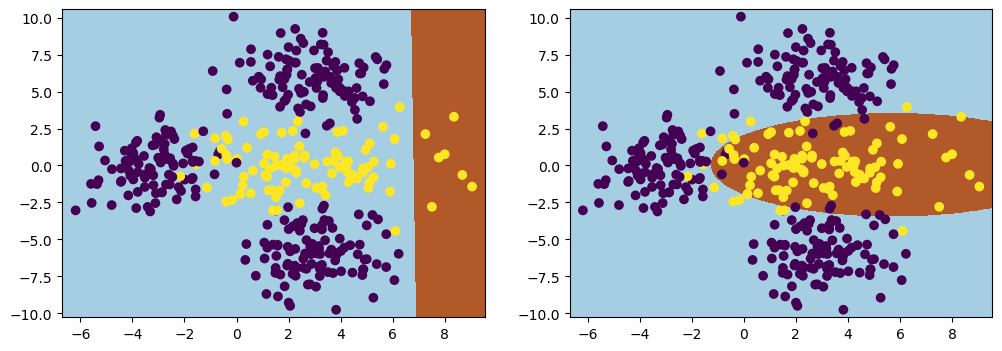

In [ ]:
plt.figure(figsize=(12, 4))

# model_lin
plt.subplot(1, 2, 1)
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.pcolormesh(xx, yy, model_lin.predict(np.concatenate([
    xx.ravel().reshape((-1,1)),yy.ravel().reshape((-1,1))], axis=1)).reshape(xx.shape),
               cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=df['y']);

# model_sq
plt.subplot(1, 2, 2)
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.pcolormesh(xx, yy, model_sq.predict(np.concatenate([
    xx.ravel().reshape((-1, 1)),yy.ravel().reshape((-1, 1)),
    xx.ravel().reshape((-1, 1))**2, yy.ravel().reshape((-1, 1))**2],
    axis=1)).reshape(xx.shape), cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=df['y']);

## Nearest Neighbor algorithm

Here you will implement one of the simplest (but quite powerful) machine learning algorithm: the *Nearest Neighbor* algorithm and its extension the *k-Nearest Neighbors* algorithm (or *kNN*). Both can be used for classification and regression tasks.

Considering a dataset $\mathcal{D}=\{(\boldsymbol{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples, the *Nearest Neighbor* model assigns an input vector $\boldsymbol{x}$ (of dimension $p$) to the label $y_{{\arg\!\min}_{i=1,\dots, n}d(x, x_i)}$ of its closest neighbor in $\mathcal{D}$.

The closest neighbor is defined w.r.t. a distance function $d$. This can be any metric measure, but the *Minkowski distance* (especially the classical Euclidian distance $d_2$) is the most common choice. It is defined as follows:

$$d_q: \mathbb{R}^p \times \mathbb{R}^p \to \mathbb{R}$$

$$d_q(\boldsymbol{u}, \boldsymbol{v}) = ||\boldsymbol{u} - \boldsymbol{v}||_q = \left( \sum_{j=1}^p |u_j - v_j|^q \right)^{1/q}$$

When $q=2$, $d_q$ is the *Euclidian distance*

$$d_2(\boldsymbol{u}, \boldsymbol{v}) = \sqrt{\sum_{j=1}^{p} (u_j - v_j)^2}$$

When $q=1$, $d_q$ is the *Manhattan distance*

$$d_1(\boldsymbol{u}, \boldsymbol{v}) = \sum_{j=1}^{p} |u_j - v_j|$$

When $q=\infty$, $d_q$ is the  *Tchebychev distance*

$$d_{\infty}(\boldsymbol{u}, \boldsymbol{v}) = \max_{j=1,\dots,p} |u_j - v_j|$$

### Exercise 4

We consider the following dataset (where `x1` and `x2` are examples' features and where `y` represents the examples' labels):

In [ ]:
data = [[0, 0, 1],
        [0, 1, 1],
        [1, 1, 2],
        [1, 0, 3]]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,0,0,1
1,0,1,1
2,1,1,2
3,1,0,3


In [ ]:
A=np.array([[1,2],[3,4]])
A.T

array([[1, 3],
       [2, 4]])

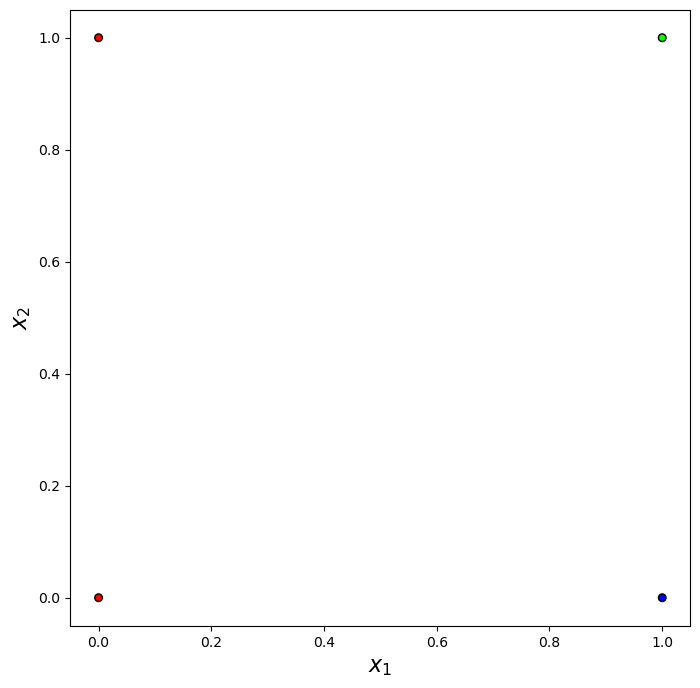

In [ ]:
plot_2d_classification_samples(df)

Which label (red/1, green/2, blue/3) will be predicted by the Nearest Neighbor algorithm for the point $x = \pmatrix{1 \\ 0.75}$ ?

The algorithm will predict green because the distance between x and the green point is the smallest one.

### Exercise 5

Consider this new dataset (where `volume (mL)` and `caffeine (g)` are the examples' features and where `drink` is their label):

In [ ]:
data = [[250, 0.025, 'tea'],
        [100, 0.01,  'tea'],
        [125, 0.05,  'coffee'],
        [250, 0.1,   'coffee']]

df = pd.DataFrame(data, columns=['volume (mL)', 'caffeine (g)', 'drink'])
df

,volume (mL),caffeine (g),drink
0,250,0.025,tea
1,100,0.010,tea
2,125,0.050,coffee
3,250,0.100,coffee


#### 5.1
Use the Nearest Neighbor method to predict the label of a 100mL drink having 0.075g of caffeine, by intuition, calculation, and / or with some code (up to you, with some justification).

We observe that the point (100,0.01) in the dataset is close to what we're looking for. Therefore, the label of a 100mL drink having 0.075g is "tea".  

In [ ]:
# Optional: provide some code to prove your answer.
# YOUR CODE HERE
nearestneighbor=sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
nearestneighbor.fit(df[['volume (mL)','caffeine (g)']],df['drink'])
p=nearestneighbor.predict([[100,0.075]])
p

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['tea'], dtype=object)

#### 5.2
What is wrong with this prediction? How to solve this problem?

In order to assess which label our drink will have, we need to check the ratio volume/caffeine, not the values themselves. Moreover,the values of caffeine amount are relatively low in numerical values compared to volumes. Therefore, a solution to this problem would be to normalize the values of our variables, meaning that we need to scale all values to the same range.

## Nearest Neighbor method with Scikit Learn

Let's play with the Scikit Learn implementation of the Nearest Neighbor algorithm.
The official documentation is there: https://scikit-learn.org/stable/modules/neighbors.html

### Classification

We begin with a "toy" **classification problem**.

Use the `gen_2d_classification_samples()` function (defined above) to generate a dataset.

In [ ]:
df = gen_2d_classification_samples(n_samples=20)
df.head()

,x1,x2,y
0,7.168108,-1.074308,2
1,2.480010,2.325874,2
2,3.526936,4.105886,3
3,-0.244115,-1.032898,1
4,2.132495,4.068303,3


Here, examples are defined in $\mathbb{R}^2$ (features are stored in columns `x1` and `x2`).
Examples' labels are defined in the `y` column. This is similar to Exercise 1.

The `y` column contains three possible labels: `1`, `2` and `3` respectively represented by the red, green and blue colors in the following figure.

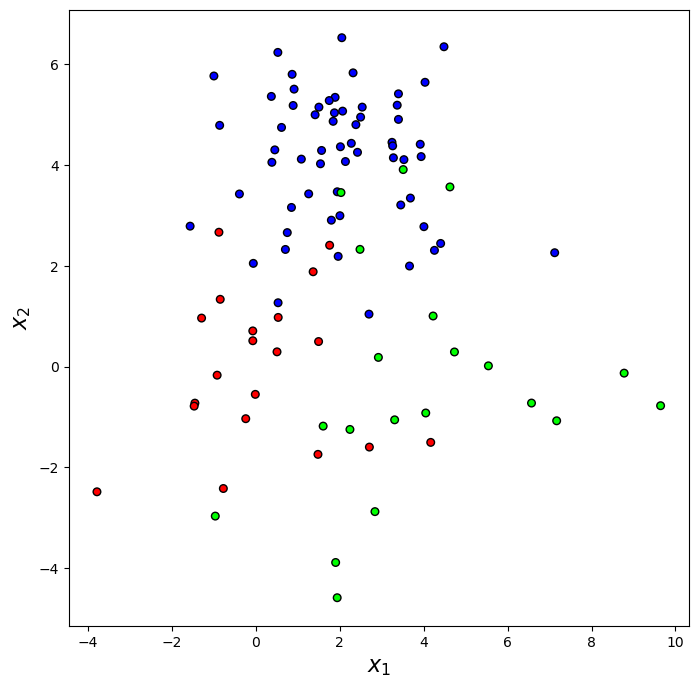

In [ ]:
plot_2d_classification_samples(df)

Thus this toy problem is a multiclass classification problem.

Once the dataset is ready, let's make the classifier and train it with the following code:

In [ ]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
# 1-NN as a special case of k-NN

In [ ]:
model.fit(X=df[['x1', 'x2']].values, y=df['y'])

KNeighborsClassifier(n_neighbors=1)

### Exercise 6

#### 6.1
Use the `model.predict()` function to guess the class of the following points:

$$x_{p1} = \pmatrix{-2 \\ 0}, x_{p2} = \pmatrix{0 \\ 6}, x_{p3} = \pmatrix{8 \\ 0}$$

Store the result in `model_predictions`.

In [ ]:
model_predictions=model.predict([[-2,0],[0,6],[8,0]])
model_predictions

array([1, 3, 2])

#### 6.2
Is the training step (`model.fit()` function) longer to execute than the prediction step (`model.predict()` function)? Why?

*An intuitive answer is expected; you don't have to time any code execution.*

The `model.fit()` function just stores the data. Moreover, as we are working with Nearest Neighbor model, there is not really a learning step, since the `model.predict()` function will compute all the distances from the new point to the points in the dataset and find the closest example to the predicted one. Hence, it is the predict function that will take longer to execute, especially when the dataset is large.

#### 6.3
The next cell shows the decision boundary of the model. Explain what is a decision boundary in classification.

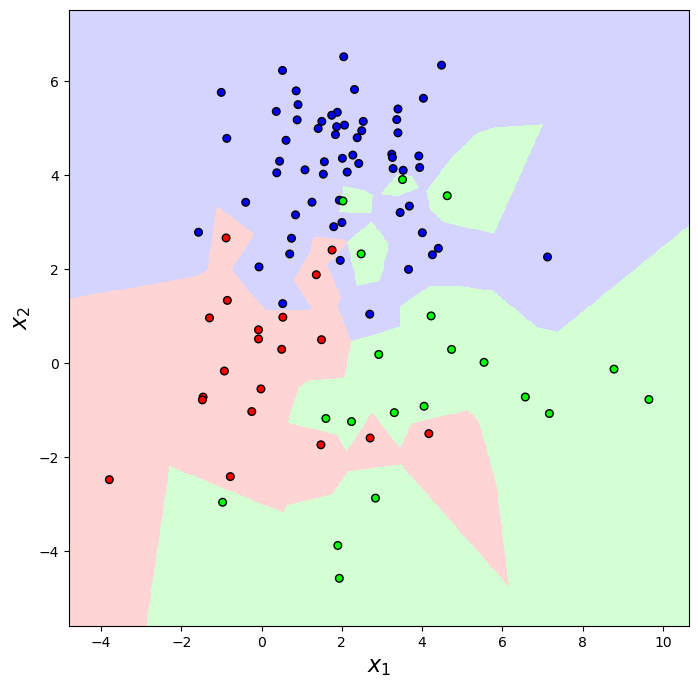

In [ ]:
plot_2d_classification_samples(df, model=model)

The plot above show the feature space, in which every point in a colored area will be have the number of the colour as its label (for example, points in a red area will have label "1"). Every colored area represents a class. The decision boundaries are the lines that separate these areas.

#### 6.4
The next cell generates the *Voronoï diagram* of the dataset. The Voronoï diagram makes a partition of the feature space $\mathcal{X}$.
Each partition is a *cell*. What do cells represent?
What does this figure illustrate about the Nearest Neighbor method?

<Figure size 800x800 with 0 Axes>

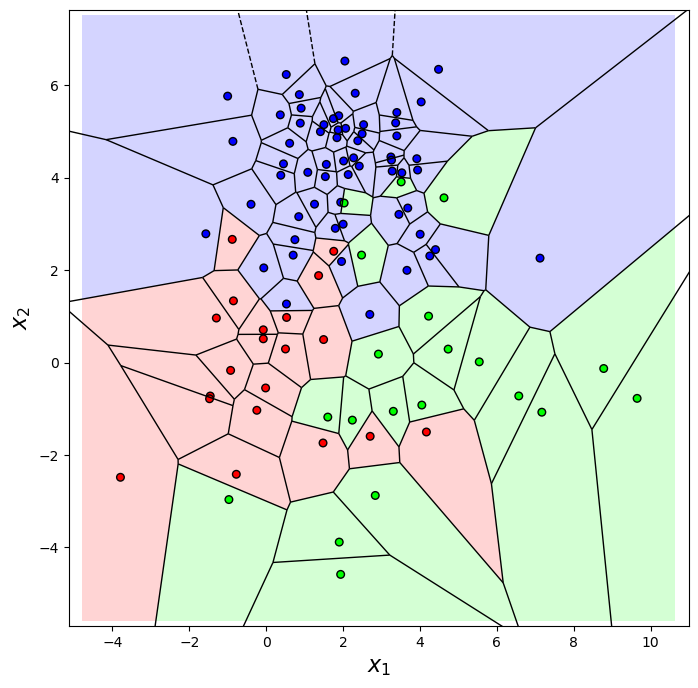

In [ ]:
plot_2d_classification_samples(df, model=model, voronoi=True);

As we can see, each cell has one unique point in it. These are all areas of influence of those points. Any input point x falling within a cell will be classified with the same label as the point from the dataset that is already in that cell. This is a clear representation of the classification that Nearest Neighbor algorithm does.

### Regression

After the "toy" classification problem, let's work on a toy **regression problem**.

The next cell generates a dataset (where 'x' is the feature and 'y' the label to predict).

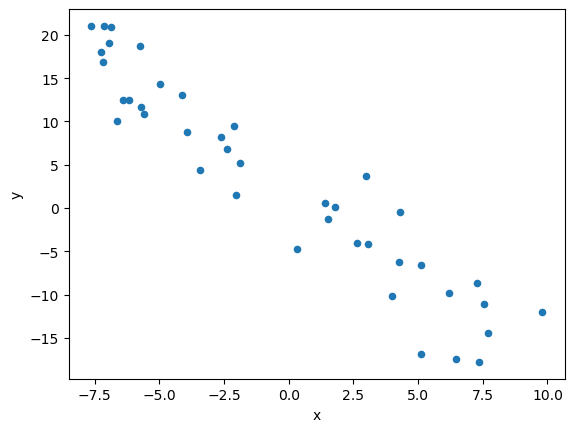

In [ ]:
df = gen_and_plot_1d_regression_samples()

Once the dataset is ready, let's make the regressor and train it with the following code:

In [ ]:
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1)

In [ ]:
model.fit(df[['x']].values, df['y'])

KNeighborsRegressor(n_neighbors=1)

### Exercise 7

#### 7.1
Use the `model.predict()` function to classify the following points:

$$x_{p1} = \pmatrix{-5}, x_{p2} = \pmatrix{0}, x_{p3} = \pmatrix{5}$$

Store it in `model_predictions_bis`.

In [ ]:
model_predictions_bis=model.predict([[-5],[0],[5]])
model.predict([[-5],[0],[5]])

array([ 14.30283144,  -4.69932486, -16.91493085])

### Plot the model's decision function

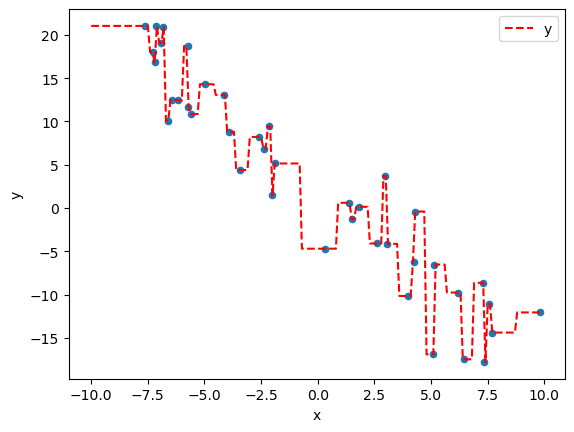

In [ ]:
x_pred = np.arange(-10, 10, 0.1).reshape(-1, 1)
y_pred = model.predict(x_pred)

df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

ax = df.plot.scatter(x='x', y='y')
df_pred.plot(x='x', y='y', style='r--', ax=ax);

#### 7.2

Do you think this model *generalizes* well (by generalization, we mean performance on unseen - test - examples drawn from the same distribution as the seen - training - examples; recall what happened with polynomial regression with a high degree)? Why?

As we can observe in the plot above, the model learns correctly the trend of the data. However, we can observe that it overfits the data, as it is taking into account the noise contained in the dataset. This will result in a poor prediction when given a new point that is not included in the data. Therefore, this model does not generalize well.

## k-Nearest Neighbors algorithm

The *Nearest Neighbor* method is very sensitive to noise: if an example in $\mathcal{D}$ is wrongly labeled or positioned, all points in its Voronoï cell will be wrong too. The *k Neareast Neighbor* fix this weakness by considering for each prediction the label of several neighbors instead of just one.

Considering a dataset $\mathcal{D}=\{(\boldsymbol{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples and a meta / hyper parameter $k \in \mathbb{N}*$, the *$k$ Nearest Neighbors* model assigns an input vector $\boldsymbol{x}$ to the label $y$ (defined below) of its $k$ closest neighbor in $\mathcal{D}$.
Let's write $\mathcal{N}_k(\boldsymbol{x})$ the set of the $k$ nearest neighbors of $\boldsymbol{x}$ in $\mathcal{D}$.

- For classification problems, the label assigned to $\boldsymbol{x}$ is the **most represented label** among the nearest neighbors (majority vote)
$$f(\boldsymbol{x}) = {\arg\!\max}_c \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} \delta(y_i, c)$$

- For regression problems, the label assigned to $\boldsymbol{x}$ is computed based on the **mean** of the labels of its nearest neighbors $\mathcal{N}_k(\boldsymbol{x})$
$$f(\boldsymbol{x}) = \frac{1}{k} \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} y_i$$

### Exercise 8

We consider the following dataset (where `x1` and `x2` are the example features and where `y` is the example label):

In [ ]:
data = [[1, 2, '+'],
        [2, 1, '+'],
        [2, 2, '-'],
        [2, 3, '+'],
        [1, 1, '-'],
        [3, 3, '+']]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,1,2,+
1,2,1,+
2,2,2,-
3,2,3,+
4,1,1,-
5,3,3,+


#### 8.1
Draw this dataset (it is OK to draw it on a sheet of paper: empty the code cell, add a Markdown cell and upload your picture by drag-and-drop; you can also make use of `df.plot`).

<AxesSubplot: xlabel='x1', ylabel='x2'>

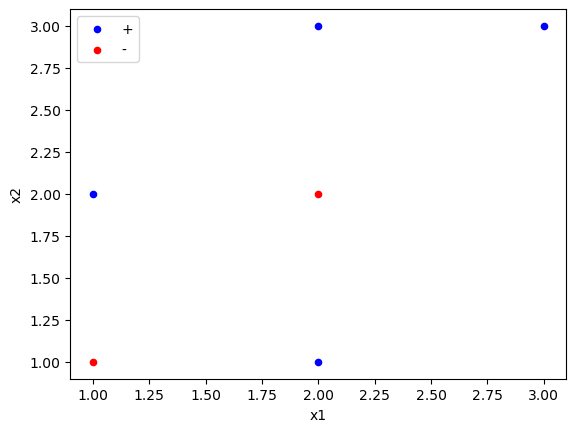

In [ ]:
ax = df.loc[df.y == "+"].plot.scatter(x = 'x1', y = 'x2', color="blue", label='+')
df.loc[df.y == "-"].plot.scatter(x ='x1', y = 'x2', ax=ax, color = "red", label='-')

#### 8.2
Draw the decision boundary of a Nearest Neighbor model (i.e. 1NN - also OK on a sheet of paper).

You may need to convert `y` to an integer type and make good use of `KNeighborsClassifier` (see Exercise 2).

In [ ]:
# YOUR CODE HERE
df_1=df.copy()
df_1['y']=df_1['y'].map({'-':1,'+':2})
df_1

,x1,x2,y
0,1,2,2
1,2,1,2
2,2,2,1
3,2,3,2
4,1,1,1
5,3,3,2


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


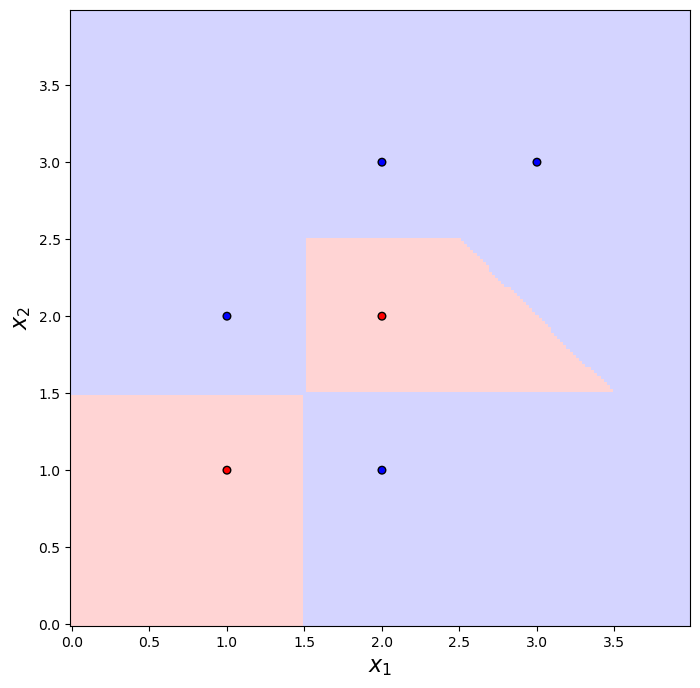

In [ ]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
model.fit(df_1[['x1','x2']],df_1['y']);
plot_2d_classification_samples(df_1, model=model)

#### 8.3
Draw the decision boundary of a 3 Nearest Neighbor model (i.e. 3NN), either with code or on a sheet of paper.

*Hint:* The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


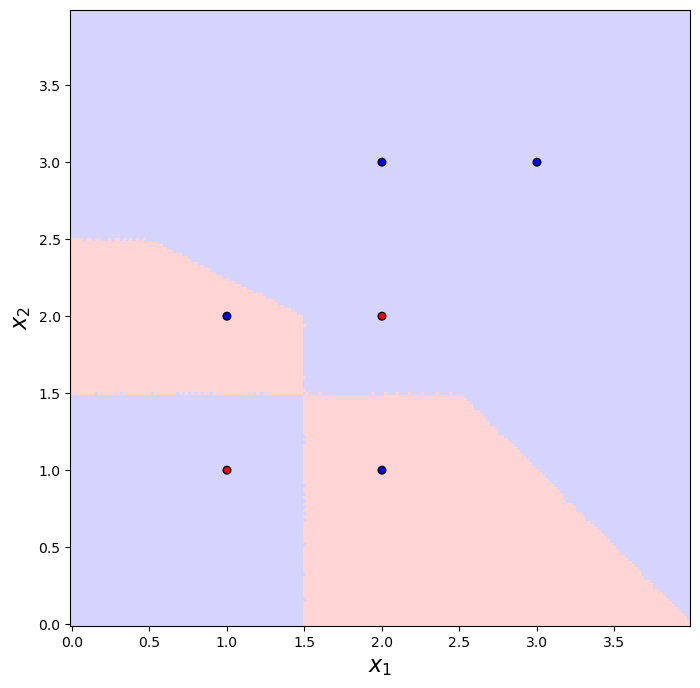

In [ ]:
# YOUR CODE HERE
model3nn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
model3nn.fit(df_1[['x1','x2']],df_1['y']);
plot_2d_classification_samples(df_1, model=model3nn)

#### 8.4
How many errors these two classifiers make on the training dataset (i.e. on the provided points with both values of $k$)?

We can see that for k=1, there are no errors (every point falls within an area of the same colour). However, for k=3, we observe 4 errors.

#### 8.5
Which label is predicted by these two classifiers for the point $x = \pmatrix{0.5 \\ 2}$?

In [ ]:
pred1nn=model.predict([[0.5,2]])
pred3nn=model3nn.predict([[0.5,2]])
print("prediction 1NN:",pred1nn, "\nprediction 3NN:", pred3nn)

prediction 1NN: [2] 
prediction 3NN: [1]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


 - 1NN's prediction is 2, which corresponds to a "+".
 - 3NN's prediction is 1, which corresponds to a "-".
 
 
 (instead of code, we could also give an answer from the plots above by plotting x in its coordinates and check in which area the point is located)

## k-Nearest Neighbor (kNN) with Scikit Learn

### Classification

First we regenerate the dataset used throughout Exercise 3.

In [ ]:
df = gen_2d_classification_samples()

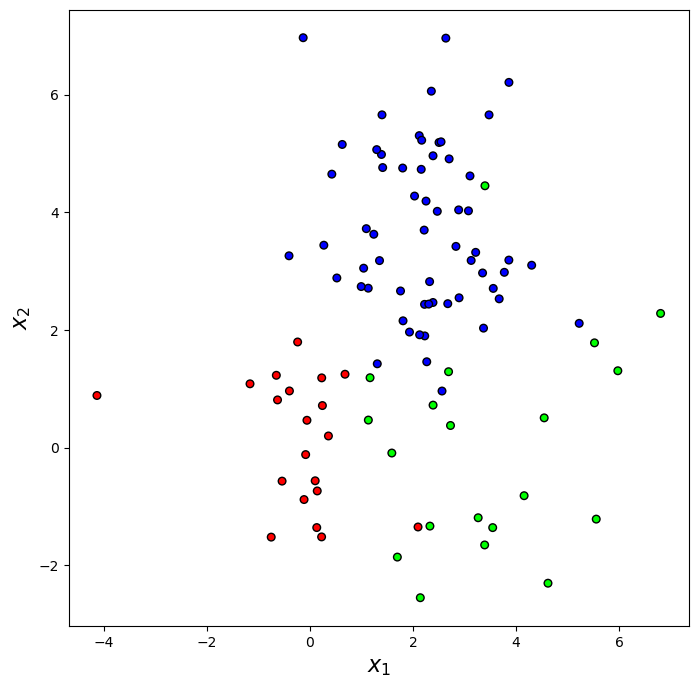

In [ ]:
plot_2d_classification_samples(df)

Then we instantiate the classifier, train it and plot the decision boundaries:

In [ ]:
def learn_knn_and_plot(**kwargs):
    """
    Learns a knn model and plot the points, their class and the decision boundaries

    :param kwargs: keyword arguments passed to KNeighborsClassifier
    """
    model = sklearn.neighbors.KNeighborsClassifier(**kwargs)
    model.fit(df[['x1', 'x2']].values, df['y'])
    plot_2d_classification_samples(df, model=model)

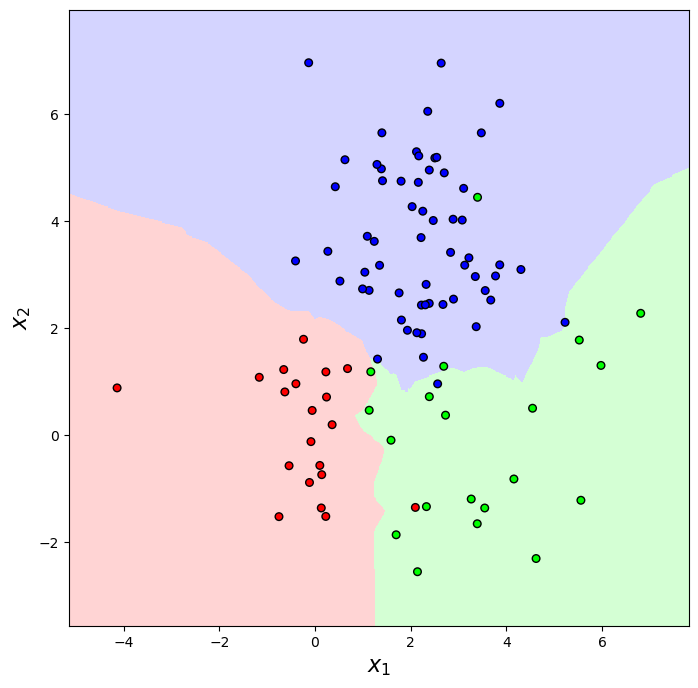

In [ ]:
learn_knn_and_plot(n_neighbors=5)

### Exercise 9

#### 9.1
Change the value of the hyperparameter $k$ in the cell above, and observe what happens, i.e. plot the resulting boundaries with the subsequent cell.

What is the influence of the number of neighbors on the boundaries? (Bonus points for the two extreme cases!)

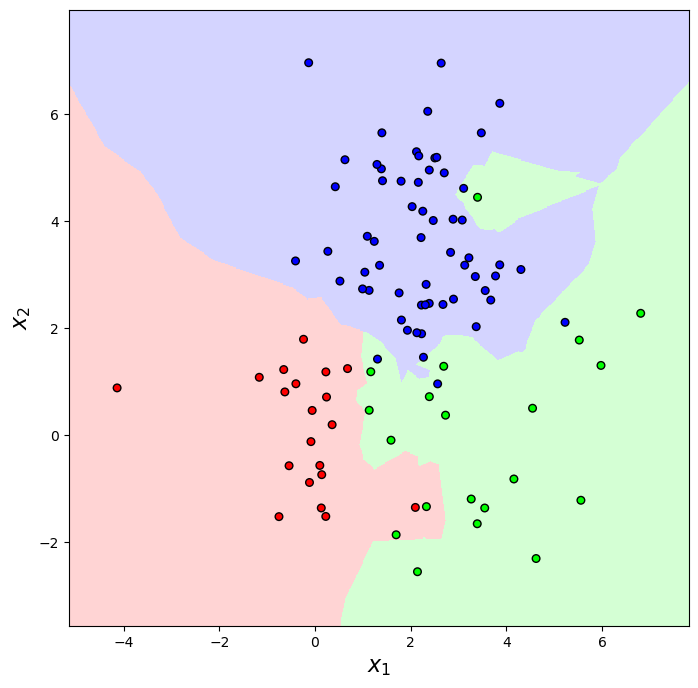

In [ ]:
learn_knn_and_plot(n_neighbors=2)

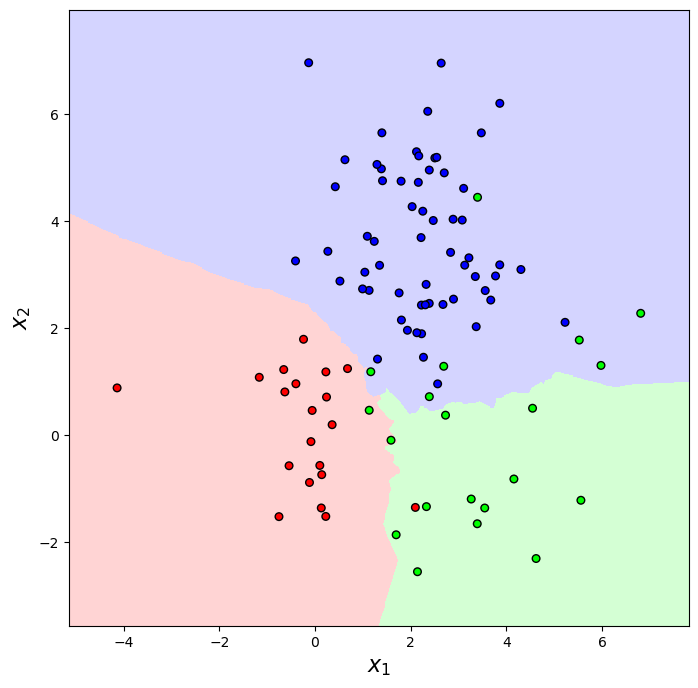

In [ ]:
learn_knn_and_plot(n_neighbors=15)

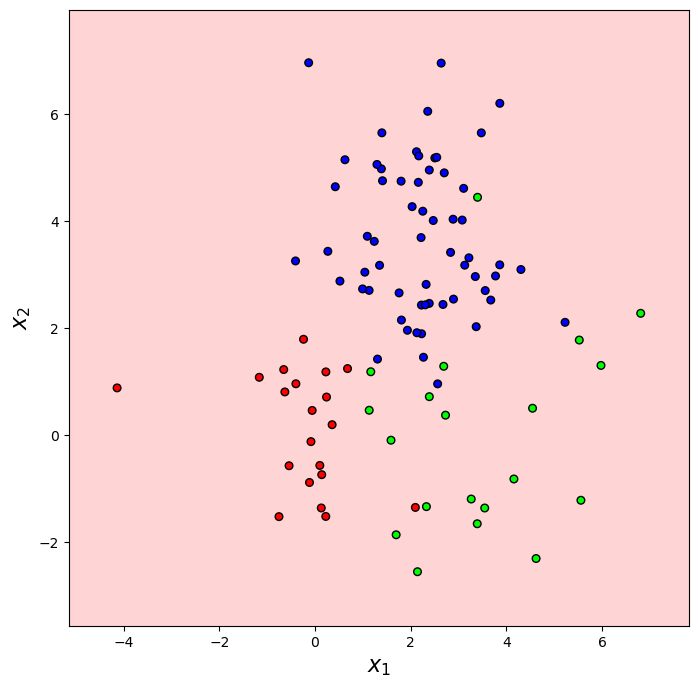

In [ ]:
learn_knn_and_plot(n_neighbors=100)

- We can see that for k=2, the model tends to overfit the data, which will lead to inaccurate results.
- For k=15, we can notice that the boundaries are a lot smoother. However, there are still some errors, as some points are located in the wrong area.
- For k=100 (larger than the number of points in our dataset), all the that will be predicted will have the label of the most represented class.

#### 9.2
When you face a very noisy dataset (wrong labels, misplaced points, ...), should you increase or decrease $k$ ?

When we face a very noisy dataset, it is better to increase k in order to make the algorithm take into account more neighbors to decrease the impact of noisy data.

#### 9.3
Is the Voronoi diagram useful for the kNN case (i.e. when $k>1$) ?

The Voronoi diagram creates a cell for each point. However, when k>1, this is not useful, as we are taking into account different points.

#### 9.4
Plot the decision boundary with $k=2$ and describe what happens in case of equal vote (copy-paste the 3 previous lines of code).

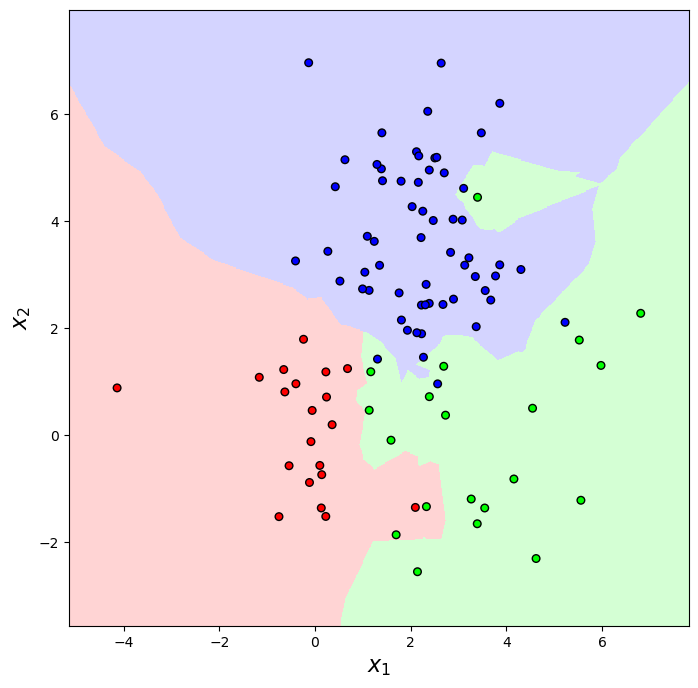

In [ ]:
learn_knn_and_plot(n_neighbors=2)
# YOUR CODE HERE

In case of equal vote, the model privileges arbitrarly a class compared to the others. In case of equal vote, we see that the first class (red) is always selected compared to the other two, then the second class (green) is selected compared to blue. 

#### 9.5
Add the `weights = "distance"` parameter in `KNeighborsClassifier`'s constructor. What changes can you observe on the decision boundary? Explain how labels are computed with this new parameter.

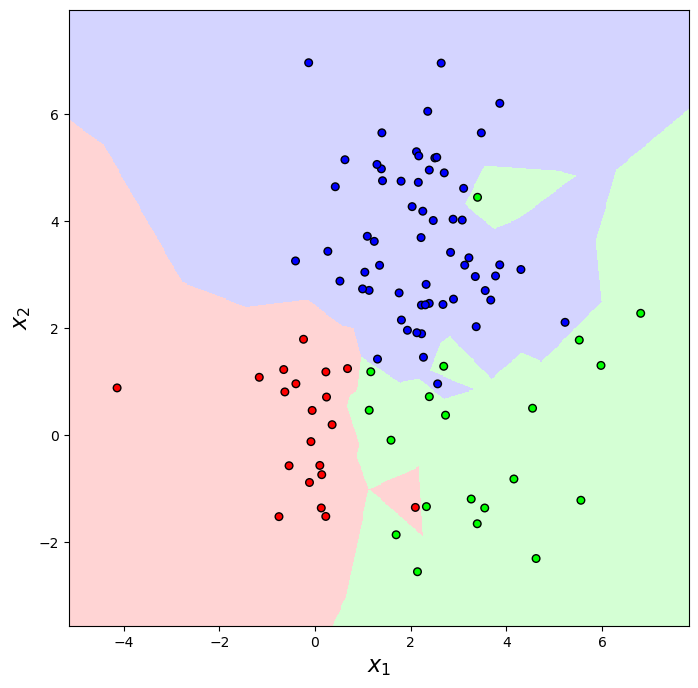

In [ ]:
learn_knn_and_plot(n_neighbors=2,weights="distance")
# YOUR CODE HERE

With this new parameter, the closest a point is to our input point, the more influence it will have on the final output. However, a drawback of this method is that the model is now more sensitive to noise in the data.

### Regression

First we regenerate the dataset from Exercise 4 - Regression with 1-NN).

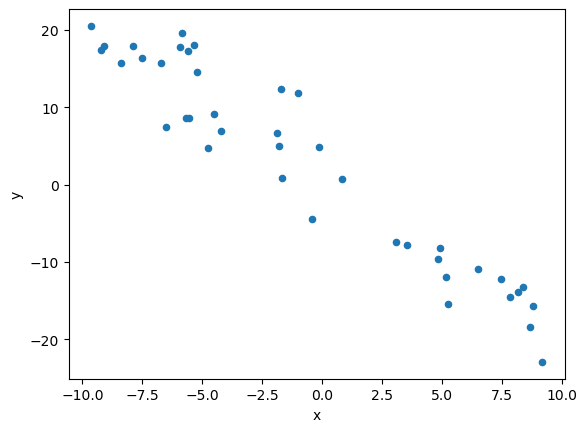

In [ ]:
df = gen_and_plot_1d_regression_samples()

Then we instantiate the classifier, train it and plot the decision boundaries:

In [ ]:
def train_and_plot_knn_regressor(**kwargs):
    """
    Instantiate, fits a KNN regressor and plots the training points as well as the predictions

    :param kwargs: keyword arguments passed to KNeighborsRegressor constructor
    """
    model = sklearn.neighbors.KNeighborsRegressor(**kwargs)
    model.fit(df[['x']].values, df['y'])

    x_pred = np.arange(-10, 10, 1).reshape(-1, 1)
    y_pred = model.predict(x_pred)

    df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

    ax = df.plot.scatter(x='x', y='y')
    df_pred.plot(x='x', y='y', style='r--', ax=ax);

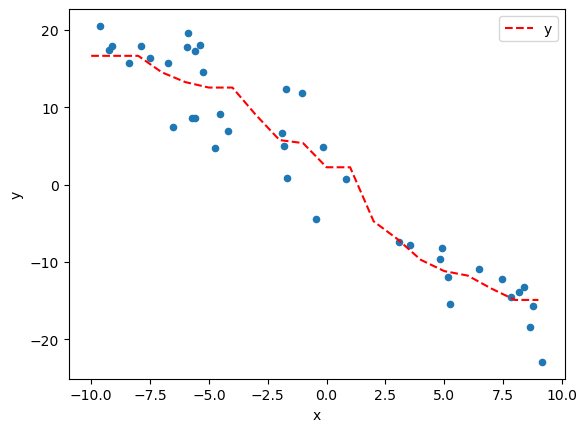

In [ ]:
train_and_plot_knn_regressor(n_neighbors=10)

### Exercise 10

*Recall*: The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).

#### 10.1
Change the value of this parameter and observe what happens.

What is the influence of the number of neighbors on the decision function (again, bonus points for extreme cases)?

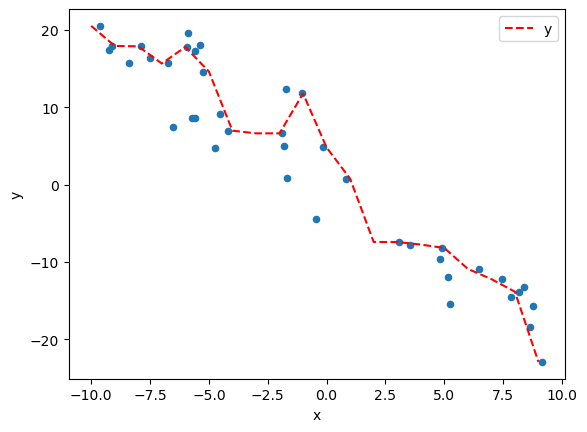

In [ ]:
train_and_plot_knn_regressor(n_neighbors=1)

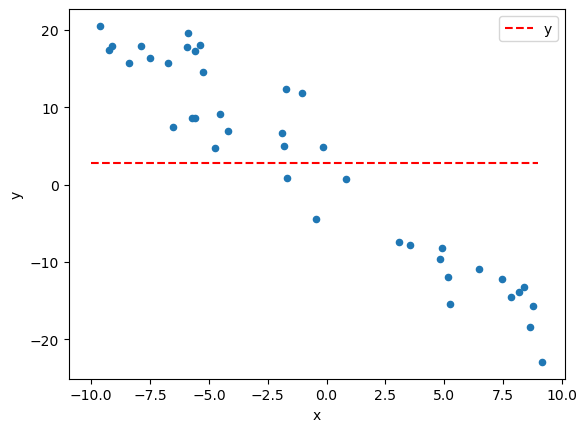

In [ ]:
train_and_plot_knn_regressor(n_neighbors=40)

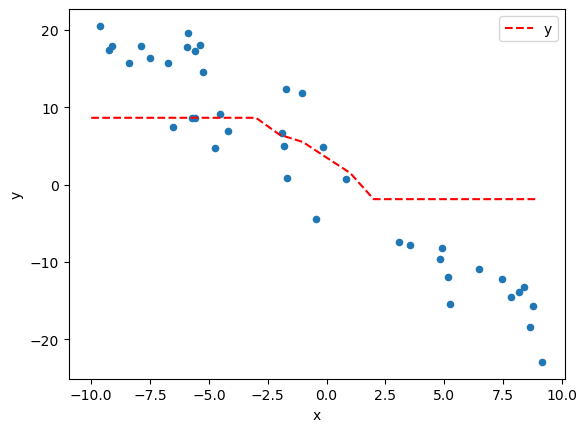

In [ ]:
train_and_plot_knn_regressor(n_neighbors=30)

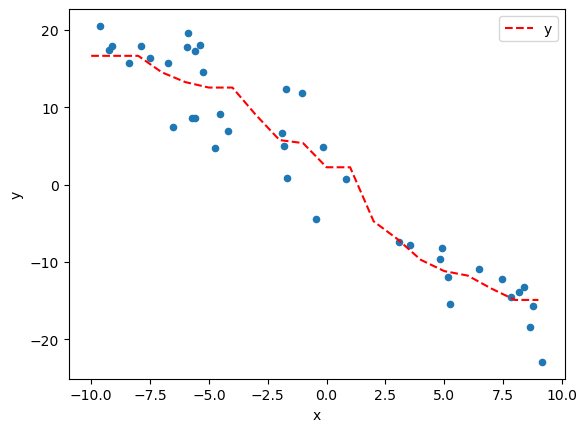

In [ ]:
train_and_plot_knn_regressor(n_neighbors=10)

- For k=1, we can see that the model is very influenced by the noise of the data. The curve depicts an overfitted model, which will give poor results when given inputs that are not in the dataset
- For k=40 (larger than our dataset), the curve is a straight line, which depicts an underfitted model, which will give poor results as it does not really take into account local trends due to the large number of neighbors.
- For k=30, the obtained model still underfits our data, as it is not capable to fit local trends.
- For k=10, we obtain a smooth curve, and the regression fits better the data.

#### 10.2
When you face a very noised dataset (wrong labels, misplaced points, ...), should you increase or decrease $k$ ?

As we saw, the more we k is small, the more sensitive the model is with respect to noise in the dataset. Therefore, we should increase k but not too much so that we do not underfit the data and get a straight line.   

## Bonus

### Exercise 11

Solve the Titanic problem with the k Nearest Neighbors method (see [`lab_session_01`](https://htmlpreview.github.io/?https://github.com/adimajo/CSE204-2021/blob/master/lab_session_01/lab_session_01.html)). Reuse the code of the first lab session:
* read the data with `read_csv`;
* select the columns useful for prediction;
* drop the missing values;
* map the categorical columns to numerical values;
* split into a training and a test subset;
* instantiate a k-NN classifier named `knn_sklearn`;
* fit the model;
* compute an accuracy score.

In [ ]:
#Loading data + data cleaning
titanic = pd.read_csv("~/shareddata/CSE204/titanic/titanic_train.csv")
titanic = titanic.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
titanic.dropna(inplace=True)
titanic['Embarked'] = titanic['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1}).astype(int)

# Training and Testing Subsets
X = titanic.drop("Survived", axis=1)  # X cannot contain the label
Y = titanic["Survived"]
X_train = X.iloc[:-10]  # all samples except 10 last ones
Y_train = Y.iloc[:-10]
X_test = X.iloc[-10:]  # 10 last samples
Y_test = Y.iloc[-10:]

#KNN
n_neighbors=3
knn_sklearn=sklearn.neighbors.KNeighborsClassifier(n_neighbors)
knn_sklearn.fit(X_train,Y_train)

#Accuracy score
print("Accuracy score (for n_neighbors =",n_neighbors,") :", knn_sklearn.score(X_test, Y_test))



Accuracy score (for n_neighbors = 3 ) : 0.9


### Exercise 12

Write your own implementation for the k Nearest Neighbor algorithm.
Write a `knn()` function that takes two arguments:
- `xtrain`: the observed dataset;
- `ytrain`: the observed labels;
- `xpred`: a list of examples to predict;
- `n_neighbors`: the number of nearest neighbors to use.

This function should return the sequence of predicted labels.

In [67]:
from math import sqrt


def knn(xtrain, ytrain, xpred, n_neighbors=5):
    """
    Predicts the y values of xpred given xtrain, ytrain, and n_neighbors-nn classification

    :param pandas.DataFrame xtrain: the training set's features (you can use numpy arrays as well)
    :param pandas.DataFrame ytrain: the training set's labels (you can use numpy arrays as well)
    :param pandas.DataFrame xpred: the test set's features (you can use numpy arrays as well)
    :param int n_neighbors: number of nearest neighbors to use
    """
    # So as not to mess up with the original dataframes
    xtrain_cpy = xtrain.copy()
    ytrain_cpy = ytrain.copy()
    xpred_cpy = xpred.copy()
    # Store the distances in a matrix
    distances = np.zeros((xtrain_cpy.shape[0], xpred_cpy.shape[0]))
    # Store the predictions in a vector
    ypred = np.zeros(xpred_cpy.shape[0])
    # You might want to reset the index (to have to correct row numbers)
    xtrain_cpy.reset_index(inplace=True, drop=True)
    xpred_cpy.reset_index(inplace=True, drop=True)
    
    # Compute distances of each row x in xtrain to each row x' in xpred and put it in `distances`
    # YOUR CODE HERE
    for i, x in xtrain_cpy.iterrows():
        for j, y in xpred_cpy.iterrows():
            distances[i][j] = sqrt(sum((x - y)**2))

    

    # Average the labels of the `n_neighbors` closest points in xtrain of each row x in xpred
    # YOUR CODE HERE
    for i in range(len(xpred)):
         for j in range(n_neighbors):
            ypred[i] += (distances[j] * ytrain[i])
         ypred[i] /= n_neighbors

    return(ypred)

In [62]:
# It is assumed you defined X_train, Y_train, X_test in Exercise 11.
your_predictions = knn(X_train, Y_train, X_test)

IndexError: invalid index to scalar variable.

In [ ]:
# It is assumed you "trained" knn_sklearn in Exercise 11.
sklearn_predictions = knn_sklearn.predict(X_test)

Are the two predictions the same?

In [61]:
assert (your_predictions == sklearn_predictions).all()

NameError: name 'your_predictions' is not defined